In [7]:

!pip install optuna-integration[sklearn]

zsh:1: no matches found: optuna-integration[sklearn]


[I 2024-10-16 05:39:13,910] A new study created in memory with name: no-name-a7da046b-23ef-44e1-8466-049cd6439dd9
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/4165949139.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/4165949139.py:62: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e0),
[I 2024-10-16 05:39:13,943] Trial 0 finished with value: 0.7564516129032258 and parameters: {'C': 0.004171040750384021, 'gamma': 0.0020720694221386567, 'kernel': 'linear'}. Best is trial 0 with value: 0.756

SVM Model Evaluation:
Accuracy: 0.8974
ROC AUC: 0.9793
PR AUC: 0.9928

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39


XGBoost Model Evaluation:
Accuracy: 0.9231
ROC AUC: 0.9690
PR AUC: 0.9892

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.93      0.97      0.95        29

    accuracy                           0.92        39
   macro avg       0.91      0.88      0.90        39
weighted avg       0.92      0.92      0.92        39


Random Forest Model Evaluation:
Accuracy: 0.9231
ROC AUC: 0.9759
PR AUC: 0.9916

Classification Report:
              precision    recall  f1-score   su

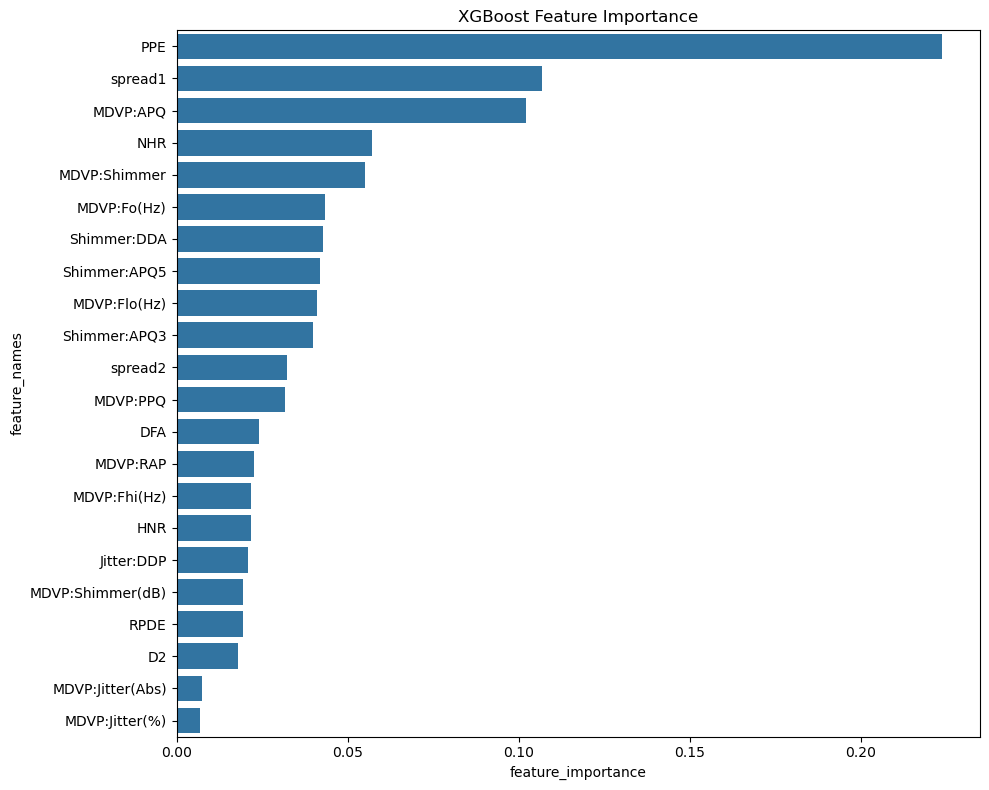

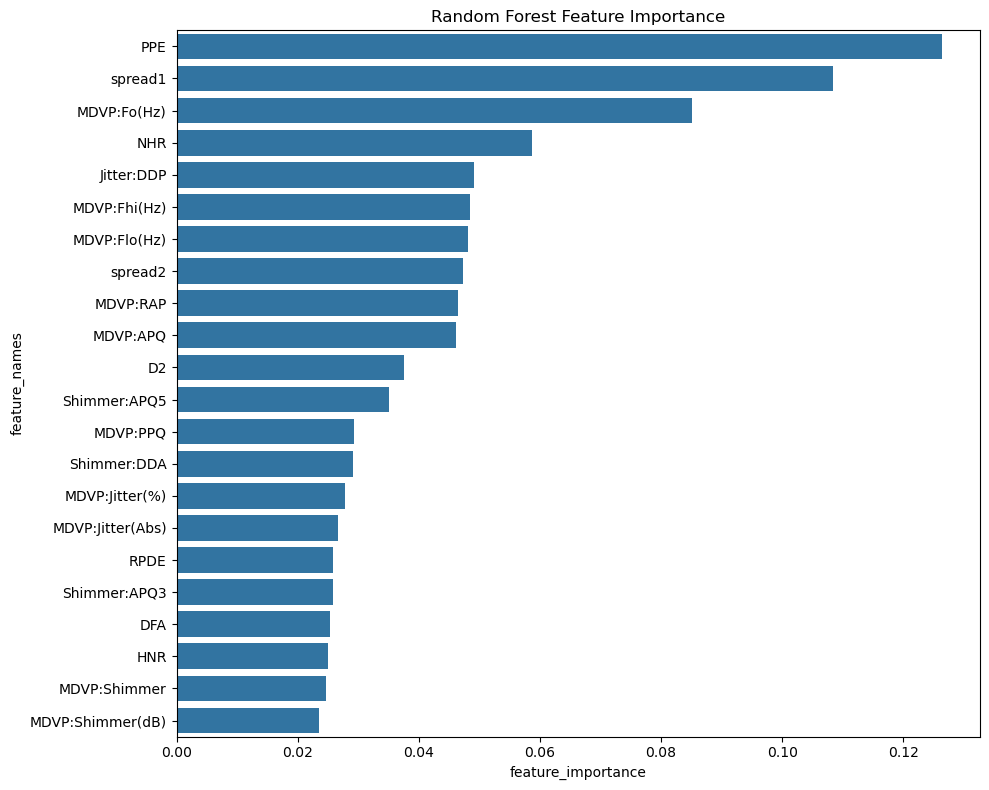


Best Parameters:
SVM: {'C': 317.23360287086115, 'gamma': 0.08252173738327201, 'kernel': 'rbf'}
XGBoost: {'max_depth': 4, 'learning_rate': 0.0517972227889723, 'n_estimators': 699, 'min_child_weight': 1, 'subsample': 0.9980756716521046, 'colsample_bytree': 0.6602016458739358}
Random Forest: {'n_estimators': 991, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot feature importance
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'{model_type} Feature Importance')
    plt.tight_layout()
    plt.show()

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Optuna optimization functions
def objective_svm(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params, probability=True)
    return np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5))

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    return np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5))

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 16)
    }
    model = RandomForestClassifier(**params)
    return np.mean(cross_val_score(model, X_train_scaled, y_train, cv=5))

# Run optimization for each model
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=100)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=100)

# Train final models with best parameters
svm_model = SVC(**study_svm.best_params, probability=True)
svm_model.fit(X_train_scaled, y_train)

xgb_model = xgb.XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

rf_model = RandomForestClassifier(**study_rf.best_params)
rf_model.fit(X_train_scaled, y_train)

# Evaluate models
print("SVM Model Evaluation:")
evaluate_model(svm_model, X_test_scaled, y_test)

print("\nXGBoost Model Evaluation:")
evaluate_model(xgb_model, X_test_scaled, y_test)

print("\nRandom Forest Model Evaluation:")
evaluate_model(rf_model, X_test_scaled, y_test)

# Plot feature importance for XGBoost and Random Forest
plot_feature_importance(xgb_model.feature_importances_, X.columns, 'XGBoost')
plot_feature_importance(rf_model.feature_importances_, X.columns, 'Random Forest')

# Print best parameters
print("\nBest Parameters:")
print("SVM:", study_svm.best_params)
print("XGBoost:", study_xgb.best_params)
print("Random Forest:", study_rf.best_params)

In [11]:
pip install pandas numpy scikit-learn optuna tensorflow shap matplotlib

Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import optuna
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# AdaBoost
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Decision Tree
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Gradient Boosting
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                       max_depth=max_depth, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# KNN
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# XGBoost (as a substitute for MobileBoost)
def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    model = xgb.XGBClassifier(**param, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Optimize and evaluate each model
models = {
    'AdaBoost': objective_adaboost,
    'Decision Tree': objective_dt,
    'Gradient Boosting': objective_gb,
    'KNN': objective_knn,
    'XGBoost': objective_xgb
}

results = {}

for name, objective in models.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    
    print(f"\n{name} Best Hyperparameters: {study.best_params}")
    print(f"{name} Best Accuracy: {study.best_value:.4f}")
    
    # Train the best model
    if name == 'XGBoost':
        best_model = xgb.XGBClassifier(**study.best_params, random_state=42)
    elif name == 'KNN':
        best_model = KNeighborsClassifier(**study.best_params)
    elif name == 'Decision Tree':
        best_model = DecisionTreeClassifier(**study.best_params, random_state=42)
    elif name == 'Gradient Boosting':
        best_model = GradientBoostingClassifier(**study.best_params, random_state=42)
    else:  # AdaBoost
        best_model = AdaBoostClassifier(**study.best_params, random_state=42)
    
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    results[name] = accuracy_score(y_test, y_pred)

print("\nFinal Results:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

print("\nBest performing model:")
best_model = max(results, key=results.get)
print(f"{best_model} with accuracy: {results[best_model]:.4f}")


[I 2024-10-14 17:28:56,877] A new study created in memory with name: no-name-30708761-72e6-4d38-aa0e-db6d18984c41
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1270082038.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-10-14 17:28:57,057] Trial 0 finished with value: 0.8205128205128205 and parameters: {'n_estimators': 228, 'learning_rate': 0.016636211065008018}. Best is trial 0 with value: 0.8205128205128205.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1270082038.py:


AdaBoost Best Hyperparameters: {'n_estimators': 329, 'learning_rate': 0.0010931402098856957}
AdaBoost Best Accuracy: 0.9231
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73         7
           1       0.91      1.00      0.96        32

    accuracy                           0.92        39
   macro avg       0.96      0.79      0.84        39
weighted avg       0.93      0.92      0.91        39



[I 2024-10-14 17:29:07,690] Trial 0 finished with value: 0.9487179487179487 and parameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:29:07,691] Trial 1 finished with value: 0.9230769230769231 and parameters: {'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:29:07,693] Trial 2 finished with value: 0.9230769230769231 and parameters: {'max_depth': 27, 'min_samples_split': 15, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:29:07,694] Trial 3 finished with value: 0.9230769230769231 and parameters: {'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:29:07,695] Trial 4 finished with value: 0.8974358974358975 and parameters: {'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 15}. Best is trial


Decision Tree Best Hyperparameters: {'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 8}
Decision Tree Best Accuracy: 0.9487
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



[I 2024-10-14 17:29:08,615] Trial 1 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 315, 'learning_rate': 0.017656631510257988, 'max_depth': 5}. Best is trial 1 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1270082038.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
[I 2024-10-14 17:29:08,654] Trial 2 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 256, 'learning_rate': 0.8128430459475101, 'max_depth': 31}. Best is trial 1 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1270082038.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.c


Gradient Boosting Best Hyperparameters: {'n_estimators': 392, 'learning_rate': 0.1567696028380375, 'max_depth': 2}
Gradient Boosting Best Accuracy: 0.9487
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



[I 2024-10-14 17:29:21,150] Trial 5 finished with value: 0.8974358974358975 and parameters: {'n_neighbors': 14, 'weights': 'uniform'}. Best is trial 1 with value: 0.9487179487179487.
[I 2024-10-14 17:29:21,153] Trial 6 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 7, 'weights': 'uniform'}. Best is trial 1 with value: 0.9487179487179487.
[I 2024-10-14 17:29:21,156] Trial 7 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 16, 'weights': 'distance'}. Best is trial 1 with value: 0.9487179487179487.
[I 2024-10-14 17:29:21,160] Trial 8 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 19, 'weights': 'distance'}. Best is trial 1 with value: 0.9487179487179487.
[I 2024-10-14 17:29:21,163] Trial 9 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 3, 'weights': 'uniform'}. Best is trial 1 with value: 0.9487179487179487.
[I 2024-10-14 17:29:21,168] Trial 10 finished with value: 0.9743589743589743 and para


KNN Best Hyperparameters: {'n_neighbors': 1, 'weights': 'distance'}
KNN Best Accuracy: 0.9744
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.97      0.98        32

    accuracy                           0.97        39
   macro avg       0.94      0.98      0.96        39
weighted avg       0.98      0.97      0.98        39



[I 2024-10-14 17:29:21,915] Trial 6 finished with value: 0.9487179487179487 and parameters: {'max_depth': 6, 'learning_rate': 0.06901542100375409, 'n_estimators': 190, 'min_child_weight': 2, 'subsample': 0.5548054300698819, 'colsample_bytree': 0.827875916852327}. Best is trial 6 with value: 0.9487179487179487.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1270082038.py:84: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1270082038.py:87: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)


XGBoost Best Hyperparameters: {'max_depth': 6, 'learning_rate': 0.06901542100375409, 'n_estimators': 190, 'min_child_weight': 2, 'subsample': 0.5548054300698819, 'colsample_bytree': 0.827875916852327}
XGBoost Best Accuracy: 0.9487
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39


Final Results:
AdaBoost: 0.9231
Decision Tree: 0.9487
Gradient Boosting: 0.9487
KNN: 0.9744
XGBoost: 0.9487

Best performing model:
KNN with accuracy: 0.9744


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import optuna
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# AdaBoost
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Decision Tree
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Gradient Boosting
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    model = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                       max_depth=max_depth, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# KNN
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# XGBoost (as a substitute for MobileBoost)
def objective_xgb(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    
    model = xgb.XGBClassifier(**param, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Optimize and evaluate each model
models = {
    'AdaBoost': objective_adaboost,
    'Decision Tree': objective_dt,
    'Gradient Boosting': objective_gb,
    'KNN': objective_knn,
    'XGBoost': objective_xgb
}

best_params = {}
results = {}

for name, objective in models.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    
    print(f"\n{name} Best Hyperparameters: {study.best_params}")
    print(f"{name} Best Accuracy: {study.best_value:.4f}")
    
    best_params[name] = study.best_params
    results[name] = study.best_value

# Train the best models
best_adaboost = AdaBoostClassifier(**best_params['AdaBoost'], random_state=42)
best_knn = KNeighborsClassifier(**best_params['KNN'])
best_xgb = xgb.XGBClassifier(**best_params['XGBoost'], random_state=42)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('adaboost', best_adaboost),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate the ensemble model
y_pred = ensemble_model.predict(X_test_scaled)

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# List down all results
print("\nFinal Results:")
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")

print("\nBest performing model:")
best_model = max(results, key=results.get)
print(f"{best_model} with accuracy: {results[best_model]:.4f}")

[I 2024-10-14 17:38:30,407] A new study created in memory with name: no-name-80d61fe6-bd7c-4f64-b002-c7a04fc8091f
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1008161297.py:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2024-10-14 17:38:30,609] Trial 0 finished with value: 0.8461538461538461 and parameters: {'n_estimators': 336, 'learning_rate': 0.00657664952926662}. Best is trial 0 with value: 0.8461538461538461.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1008161297.py:3


AdaBoost Best Hyperparameters: {'n_estimators': 179, 'learning_rate': 0.0012574038517061297}
AdaBoost Best Accuracy: 0.9231


[I 2024-10-14 17:38:41,149] Trial 35 finished with value: 0.9230769230769231 and parameters: {'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:38:41,156] Trial 36 finished with value: 0.9487179487179487 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:38:41,163] Trial 37 finished with value: 0.8974358974358975 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:38:41,169] Trial 38 finished with value: 0.9230769230769231 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9487179487179487.
[I 2024-10-14 17:38:41,175] Trial 39 finished with value: 0.8717948717948718 and parameters: {'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 4}. Best is tria


Decision Tree Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 9}
Decision Tree Best Accuracy: 0.9487


[I 2024-10-14 17:38:41,856] Trial 0 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 278, 'learning_rate': 0.009998823860954893, 'max_depth': 21}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1008161297.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1.0)
[I 2024-10-14 17:38:41,956] Trial 1 finished with value: 0.9230769230769231 and parameters: {'n_estimators': 195, 'learning_rate': 0.11373325848312832, 'max_depth': 15}. Best is trial 0 with value: 0.9230769230769231.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1008161297.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github


Gradient Boosting Best Hyperparameters: {'n_estimators': 494, 'learning_rate': 0.6331350355317108, 'max_depth': 2}
Gradient Boosting Best Accuracy: 0.9487


[I 2024-10-14 17:38:50,869] Trial 39 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 3, 'weights': 'uniform'}. Best is trial 4 with value: 0.9743589743589743.
[I 2024-10-14 17:38:50,874] Trial 40 finished with value: 0.9230769230769231 and parameters: {'n_neighbors': 16, 'weights': 'distance'}. Best is trial 4 with value: 0.9743589743589743.
[I 2024-10-14 17:38:50,879] Trial 41 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 1, 'weights': 'uniform'}. Best is trial 4 with value: 0.9743589743589743.
[I 2024-10-14 17:38:50,885] Trial 42 finished with value: 0.9487179487179487 and parameters: {'n_neighbors': 2, 'weights': 'uniform'}. Best is trial 4 with value: 0.9743589743589743.
[I 2024-10-14 17:38:50,890] Trial 43 finished with value: 0.9743589743589743 and parameters: {'n_neighbors': 1, 'weights': 'uniform'}. Best is trial 4 with value: 0.9743589743589743.
[I 2024-10-14 17:38:50,896] Trial 44 finished with value: 0.8974358974358975 and pa


KNN Best Hyperparameters: {'n_neighbors': 1, 'weights': 'distance'}
KNN Best Accuracy: 0.9744


[I 2024-10-14 17:38:51,509] Trial 6 finished with value: 0.9487179487179487 and parameters: {'max_depth': 3, 'learning_rate': 0.05937797203321385, 'n_estimators': 397, 'min_child_weight': 4, 'subsample': 0.6668997189852377, 'colsample_bytree': 0.7808348916547243}. Best is trial 6 with value: 0.9487179487179487.
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1008161297.py:85: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_3597/1008161297.py:88: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0


XGBoost Best Hyperparameters: {'max_depth': 3, 'learning_rate': 0.05937797203321385, 'n_estimators': 397, 'min_child_weight': 4, 'subsample': 0.6668997189852377, 'colsample_bytree': 0.7808348916547243}
XGBoost Best Accuracy: 0.9487

Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39

Ensemble Model Accuracy: 0.9487

Final Results:
AdaBoost: 0.9231
Decision Tree: 0.9487
Gradient Boosting: 0.9487
KNN: 0.9744
XGBoost: 0.9487

Best performing model:
KNN with accuracy: 0.9744


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import optuna
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.svm import SVC
import random

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Multi-Agent Salp Swarm (MASS) Algorithm Implementation
def mass_algorithm(objective, n_agents=10, n_iterations=100):
    best_solution = None
    best_score = -np.inf

    # Initialize agents
    agents = [objective() for _ in range(n_agents)]
    agent_scores = [objective_wrapper(agent, models_mass[current_model], X_train_scaled, X_test_scaled, y_train, y_test) for agent in agents]

    for iteration in range(n_iterations):
        # Update leader (the agent with the best score)
        leader_idx = np.argmax(agent_scores)
        leader = agents[leader_idx]

        # Update the position of each agent
        for i in range(n_agents):
            if i == leader_idx:
                continue

            # Update position based on leader and a random exploration factor
            c1 = random.uniform(0, 1)
            if c1 < 0.5:
                agents[i] = leader  # Move towards leader with some random adjustments
            else:
                agents[i] = objective()  # Randomly reinitialize agent

            # Evaluate the new position
            agent_scores[i] = objective_wrapper(agents[i], models_mass[current_model], X_train_scaled, X_test_scaled, y_train, y_test)

            # Update the best solution if found
            if agent_scores[i] > best_score:
                best_solution = agents[i]
                best_score = agent_scores[i]

    return best_solution, best_score

# Objective function wrapper for MASS Algorithm
def objective_wrapper(trial, model, X_train, X_test, y_train, y_test):
    model.set_params(**trial.params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Models and their parameter ranges for MASS Algorithm
models_mass = {
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(random_state=42)
}

# Parameter grids for each model
param_grids = {
    'AdaBoost': {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0]
    },
    'Decision Tree': {
        'max_depth': [1, 5, 10, 15, 20, 25, 32],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 5, 10, 15, 20]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
        'max_depth': [1, 5, 10, 15, 20, 25, 32]
    },
    'KNN': {
        'n_neighbors': [1, 5, 10, 15, 20],
        'weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'max_depth': [1, 3, 5, 7, 9],
        'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0],
        'n_estimators': [50, 100, 200, 300, 400, 500],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.5, 0.7, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.7, 0.9, 1.0]
    }
}

# Run MASS Algorithm for each model
mass_results = {}

for name, model in models_mass.items():
    current_model = name

    def objective():
        params = {key: random.choice(values) for key, values in param_grids[name].items()}
        trial = optuna.trial.FixedTrial(params)
        return trial

    best_solution, best_score = mass_algorithm(objective)
    mass_results[name] = best_score

    print(f"\n{name} Best Score using MASS Algorithm: {best_score:.4f}")

# Create an ensemble model using VotingClassifier
best_params = best_solution.params
best_adaboost = AdaBoostClassifier(**best_params, random_state=42)
best_knn = KNeighborsClassifier(**best_params)
best_xgb = xgb.XGBClassifier(**best_params, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('adaboost', best_adaboost),
    ('knn', best_knn),
    ('xgb', best_xgb)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate the ensemble model
y_pred = ensemble_model.predict(X_test_scaled)

print("\nEnsemble Model Classification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# List down all results
print("\nFinal Results:")
for name, accuracy in mass_results.items():
    print(f"{name}: {accuracy:.4f}")

print("\nBest performing model:")
best_model = max(mass_results, key=mass_results.get)
print(f"{best_model} with accuracy: {mass_results[best_model]:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana


AdaBoost Best Score using MASS Algorithm: 0.8718

Decision Tree Best Score using MASS Algorithm: 0.9231

Gradient Boosting Best Score using MASS Algorithm: 0.9487

KNN Best Score using MASS Algorithm: 0.9487

XGBoost Best Score using MASS Algorithm: 0.9487

Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39

Ensemble Model Accuracy: 0.9487

Final Results:
AdaBoost: 0.8718
Decision Tree: 0.9231
Gradient Boosting: 0.9487
KNN: 0.9487
XGBoost: 0.9487

Best performing model:
Gradient Boosting with accuracy: 0.9487


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create individual models
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Create ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('adaboost', ada_model),
    ('knn', knn_model),
    ('xgb', xgb_model)
], voting='soft')

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = ensemble_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Ensemble Model Accuracy: 0.9487

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Optuna optimization functions with increased trials and complexity
def objective_svm(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params, probability=True)
    return np.mean(cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5)))

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    return np.mean(cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5)))

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 16)
    }
    model = RandomForestClassifier(**params)
    return np.mean(cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5)))

# Run optimization for each model
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=200)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=200)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=200)

# Train final models with best parameters using selected features
svm_model = SVC(**study_svm.best_params, probability=True)
svm_model.fit(X_train_rfe, y_train)

xgb_model = xgb.XGBClassifier(**study_xgb.best_params, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_rfe, y_train)

rf_model = RandomForestClassifier(**study_rf.best_params)
rf_model.fit(X_train_rfe, y_train)

# Evaluate models using selected features
print("SVM Model Evaluation:")
evaluate_model(svm_model, X_test_rfe, y_test)

print("\nXGBoost Model Evaluation:")
evaluate_model(xgb_model, X_test_rfe, y_test)

print("\nRandom Forest Model Evaluation:")
evaluate_model(rf_model, X_test_rfe, y_test)

# Ensemble method: Voting Classifier for potential improvement in accuracy
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_model), 
    ('xgb', xgb_model), 
    ('rf', rf_model)], voting='soft')
voting_clf.fit(X_train_rfe,y_train)

print("\nVoting Classifier Evaluation:")
evaluate_model(voting_clf,X_test_rfe,y_test)

# Print best parameters
print("\nBest Parameters:")
print("SVM:", study_svm.best_params)
print("XGBoost:", study_xgb.best_params)
print("Random Forest:", study_rf.best_params)

[I 2024-10-23 21:57:31,765] A new study created in memory with name: no-name-18c59440-8963-4a22-863e-9e3cd6a10c88
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_67492/1736245963.py:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_67492/1736245963.py:62: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e0),
[I 2024-10-23 21:57:31,805] Trial 0 finished with value: 0.8340425531914895 and parameters: {'C': 1.8824229552452885, 'gamma': 0.09619091029047441, 'kernel': 'linear'}. Best is trial 0 with value: 0.83404

SVM Model Evaluation:
Accuracy: 0.9661
ROC AUC: 0.9931
PR AUC: 0.9923

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        29

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59


XGBoost Model Evaluation:
Accuracy: 0.9492
ROC AUC: 0.9701
PR AUC: 0.9303

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.96      0.93      0.95        29

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59


Random Forest Model Evaluation:
Accuracy: 0.9322
ROC AUC: 0.9874
PR AUC: 0.9868

Classification Report:
              precision    recall  f1-score   su

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:05:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Voting Classifier Evaluation:
Accuracy: 0.9492
ROC AUC: 0.9897
PR AUC: 0.9877

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.96      0.93      0.95        29

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59


Best Parameters:
SVM: {'C': 49.608932890016504, 'gamma': 0.9478284616437063, 'kernel': 'rbf'}
XGBoost: {'max_depth': 7, 'learning_rate': 0.7492542242297053, 'n_estimators': 519, 'min_child_weight': 1, 'subsample': 0.9087279125389819, 'colsample_bytree': 0.5335313055503002}
Random Forest: {'n_estimators': 799, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_recall_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, BaggingClassifier
import xgboost as xgb
import optuna
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Load Dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data'
df = pd.read_csv(url)

# Drop 'name' column and separate features (X) and target (y)
X = df.drop(columns=['name', 'status'])
y = df['status']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using Recursive Feature Elimination (RFE)
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Optuna optimization functions with increased trials and complexity
def objective_svm(trial):
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    }
    model = SVC(**params, probability=True)
    return np.mean(cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5)))

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss')
    return np.mean(cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5)))

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 16),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 16)
    }
    model = RandomForestClassifier(**params)
    return np.mean(cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5)))

# Run optimization for each model
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=200)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=200)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=200)

# Train final models with best parameters using selected features
svm_model = SVC(**study_svm.best_params, probability=True)
svm_model.fit(X_train_rfe, y_train)

xgb_model = xgb.XGBClassifier(**study_xgb.best_params)
xgb_model.fit(X_train_rfe,y_train)

rf_model = RandomForestClassifier(**study_rf.best_params)
rf_model.fit(X_train_rfe,y_train)

# Evaluate models using selected features
print("SVM Model Evaluation:")
evaluate_model(svm_model,X_test_rfe,y_test)

print("\nXGBoost Model Evaluation:")
evaluate_model(xgb_model,X_test_rfe,y_test)

print("\nRandom Forest Model Evaluation:")
evaluate_model(rf_model,X_test_rfe,y_test)

# Ensemble method: Voting Classifier for potential improvement in accuracy
voting_clf = VotingClassifier(estimators=[
    ('svm', svm_model), 
    ('xgb', xgb_model), 
    ('rf', rf_model)], voting='soft')
voting_clf.fit(X_train_rfe,y_train)

print("\nVoting Classifier Evaluation:")
evaluate_model(voting_clf,X_test_rfe,y_test)

# Additional Ensemble Techniques

# AdaBoost with Random Forest as base estimator
ada_clf = AdaBoostClassifier(base_estimator=rf_model,n_estimators=50)
ada_clf.fit(X_train_rfe,y_train)
print("\nAdaBoost Classifier Evaluation:")
evaluate_model(ada_clf,X_test_rfe,y_test)

# Bagging with SVM as base estimator
bagging_clf = BaggingClassifier(base_estimator=svm_model,n_estimators=50,max_samples=0.8,max_features=0.8,oob_score=True)
bagging_clf.fit(X_train_rfe,y_train)
print("\nBagging Classifier Evaluation:")
evaluate_model(bagging_clf,X_test_rfe,y_test)

# Stacking Classifier combining all models
stacking_clf = VotingClassifier(estimators=[
    ('svm', svm_model), 
    ('xgb', xgb_model), 
    ('rf', rf_model),
    ('ada', ada_clf),
    ('bagging', bagging_clf)], voting='soft')
stacking_clf.fit(X_train_rfe,y_train)

print("\nStacking Classifier Evaluation:")
evaluate_model(stacking_clf,X_test_rfe,y_test)

# Print best parameters for reference
print("\nBest Parameters:")
print("SVM:", study_svm.best_params)
print("XGBoost:", study_xgb.best_params)
print("Random Forest:", study_rf.best_params)

[I 2024-10-23 22:10:49,614] A new study created in memory with name: no-name-a1b1f6ee-e5ba-4d78-86d7-87b9c4d0fb5a
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_67492/699224049.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-3, 1e3),
/var/folders/b7/fvm8bd317t9f9_j96tkt0q800000gn/T/ipykernel_67492/699224049.py:60: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e0),
[I 2024-10-23 22:10:49,629] Trial 0 finished with value: 0.8382978723404255 and parameters: {'C': 0.06594586207874648, 'gamma': 0.21072427586550496, 'kernel': 'linear'}. Best is trial 0 with value: 0.838297

SVM Model Evaluation:
Accuracy: 0.9661
ROC AUC: 0.9931
PR AUC: 0.9923

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        30
           1       0.97      0.97      0.97        29

    accuracy                           0.97        59
   macro avg       0.97      0.97      0.97        59
weighted avg       0.97      0.97      0.97        59


XGBoost Model Evaluation:
Accuracy: 0.9492
ROC AUC: 0.9747
PR AUC: 0.9663

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.96      0.93      0.95        29

    accuracy                           0.95        59
   macro avg       0.95      0.95      0.95        59
weighted avg       0.95      0.95      0.95        59


Random Forest Model Evaluation:
Accuracy: 0.9322
ROC AUC: 0.9897
PR AUC: 0.9886

Classification Report:
              precision    recall  f1-score   su

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator'

In [22]:
from qiskit import QuantumCircuit, execute
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_aer import Aer  # Updated import for Aer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load and preprocess the dataset
data = pd.read_csv('parkinsons.data')
X = data.drop(['name', 'status'], axis=1)
y = data['status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a feature map for encoding data into quantum states
feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2)

# Create a quantum kernel instance
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

# Train a support vector machine using the quantum kernel
svc = SVC(kernel='precomputed')
kernel_matrix_train = quantum_kernel.evaluate(x_vec=X_train)
svc.fit(kernel_matrix_train, y_train)

# Evaluate on test set
kernel_matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
accuracy = svc.score(kernel_matrix_test, y_test)

print(f"Test set accuracy: {accuracy:.2f}")

ImportError: cannot import name 'execute' from 'qiskit' (/opt/anaconda3/lib/python3.12/site-packages/qiskit/__init__.py)

In [18]:
python -m ipykernel install --user --name=qiskitenv --display-name "Python (qiskitenv)"

SyntaxError: invalid syntax (2718396841.py, line 1)

In [24]:
pip install qiskit qiskit-aer qiskit-machine-learning pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.4 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3565 sha256=d4b531abea33d886f9f99780af862e70fd4a3c8a4e1e8c06e363f33d375d36c1
  Stored in directory: /Users/kazi/Library/Caches/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


In [26]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_aer import Aer  # Ensure you have qiskit-aer installed
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Load and preprocess the dataset
data = pd.read_csv('parkinsons.data')
X = data.drop(['name', 'status'], axis=1)
y = data['status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a feature map for encoding data into quantum states
feature_map = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=2)

# Create a quantum kernel instance
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

# Train a support vector machine using the quantum kernel
svc = SVC(kernel='precomputed')
kernel_matrix_train = quantum_kernel.evaluate(x_vec=X_train)
svc.fit(kernel_matrix_train, y_train)

# Evaluate on test set
kernel_matrix_test = quantum_kernel.evaluate(x_vec=X_test, y_vec=X_train)
accuracy = svc.score(kernel_matrix_test, y_test)

print(f"Test set accuracy: {accuracy:.2f}")

ImportError: cannot import name 'QuantumKernel' from 'qiskit_machine_learning.kernels' (/opt/anaconda3/lib/python3.12/site-packages/qiskit_machine_learning/kernels/__init__.py)

In [28]:
pip install qiskit qiskit-aer qiskit-machine-learning

Note: you may need to restart the kernel to use updated packages.
